In [17]:
! nvidia-smi

Fri Nov 15 21:55:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.70                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P5             19W /  107W |     140MiB /  16384MiB |     42%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
import torch
print(torch.__version__)  # Check installed version
print(torch.cuda.is_available())  # Should return True if your GPU is working with PyTorch


2.0.1+cu117
True


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [20]:
import os
import cv2
import xml.etree.ElementTree as ET

def load_data(images_path, annotations_path):
    images = []
    annotations = []
    image_filenames_with_annotations = []

    # Step 1: Gather all image filenames that have corresponding annotations
    for xml_file in os.listdir(annotations_path):
        if xml_file.endswith('.xml'):
            tree = ET.parse(os.path.join(annotations_path, xml_file))
            root = tree.getroot()
            image_file = root.find('filename').text
            image_filenames_with_annotations.append(image_file)

    # Step 2: Load only the images that have corresponding annotations
    for image_file in os.listdir(images_path):
        if image_file in image_filenames_with_annotations:
            image_path = os.path.join(images_path, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                images.append(image)

    # Step 3: Load corresponding annotations
    for xml_file in os.listdir(annotations_path):
        if xml_file.endswith('.xml'):
            tree = ET.parse(os.path.join(annotations_path, xml_file))
            root = tree.getroot()
            image_file = root.find('filename').text
            if image_file in image_filenames_with_annotations:
                img_annotations = []
                for obj in root.findall('object'):
                    class_id = obj.find('name').text
                    bndbox = obj.find('bndbox')
                    x_min = int(bndbox.find('xmin').text)
                    y_min = int(bndbox.find('ymin').text)
                    x_max = int(bndbox.find('xmax').text)
                    y_max = int(bndbox.find('ymax').text)
                    img_annotations.append((class_id, (x_min, y_min, x_max, y_max)))
                annotations.append((image_file, img_annotations))

    return images, annotations

# Paths to dataset
train_images_path = r"C:\Users\Sai Madhu\Downloads\RDD2022_India\India\train\images"
train_annotations_path = r"C:\Users\Sai Madhu\Downloads\RDD2022_India\India\train\annotations\xmls"

# Load data
train_images, train_annotations = load_data(train_images_path, train_annotations_path)

# Step 4: Print the number of images and annotations after filtering
print(f"Number of images: {len(train_images)}, Number of annotations: {len(train_annotations)}")


Number of images: 7706, Number of annotations: 7706


In [21]:
print(f"Number of images: {len(train_images)}, Number of annotations: {len(train_annotations)}")

Number of images: 7706, Number of annotations: 7706


In [22]:
import numpy as np

# Resize all images to a fixed size (224x224 for example) and normalize annotations
def preprocess_data(images, annotations, target_size=(224, 224)):
    processed_images = []
    processed_annotations = []

    for img, ann in zip(images, annotations):
        # Resize image
        img_resized = cv2.resize(img, target_size)
        processed_images.append(img_resized)
        
        # Normalize annotations (bounding boxes)
        img_annotations = []
        for class_id, (x_min, y_min, x_max, y_max) in ann[1]:
            img_height, img_width, _ = img.shape
            x_min_norm = x_min / img_width
            y_min_norm = y_min / img_height
            x_max_norm = x_max / img_width
            y_max_norm = y_max / img_height
            img_annotations.append((class_id, (x_min_norm, y_min_norm, x_max_norm, y_max_norm)))
        processed_annotations.append(img_annotations)

    return np.array(processed_images), processed_annotations

# Preprocess the loaded data
X_train, y_train = preprocess_data(train_images, train_annotations)

In [23]:
print(f"X_train: {len(X_train)}, y_train: {len(y_train)}")

X_train: 7706, y_train: 7706


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 6164, Validation samples: 1542


In [25]:
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 6164, Validation samples: 1542


In [26]:
# Step 1: Import Required Libraries

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import Sequence

In [27]:
# Step 2: Create a Data Generator


class ObjectDetectionGenerator(Sequence):
    def __init__(self, images, annotations, batch_size=16, input_size=(224, 224)):
        self.images = images
        self.annotations = annotations
        self.batch_size = batch_size
        self.input_size = input_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_images = self.images[index * self.batch_size:(index + 1) * self.batch_size]
        batch_annotations = self.annotations[index * self.batch_size:(index + 1) * self.batch_size]
        
        return self.__data_generation(batch_images, batch_annotations)

    def __data_generation(self, batch_images, batch_annotations):
        X = np.zeros((len(batch_images), *self.input_size, 3))
        y = np.zeros((len(batch_images), 4))  # Assuming 4 values for bounding box (x_min, y_min, x_max, y_max)
        
        for i, (img, ann) in enumerate(zip(batch_images, batch_annotations)):
            X[i,] = img / 255.0  # Normalize the image
            
            if ann:  # Check if there are annotations
                # Here, we take the first annotation as an example (you may need to adjust this)
                class_id, (x_min, y_min, x_max, y_max) = ann[0]  # Assuming one box per image for simplicity
                y[i,] = [x_min, y_min, x_max, y_max]  # Store bounding box
            
        return X, y



In [28]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Check if a GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available. Using GPU.")
else:
    print("No GPU found. Using CPU.")

# Define the R-CNN Model
def create_rcnn_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add R-CNN layers
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(4, activation='sigmoid')(x)  # Assuming bounding box output

    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  # Use appropriate loss for bounding box regression
    return model

# Force TensorFlow to use the GPU if available
with tf.device('/GPU:0'):  # Use '/GPU:0' for the first GPU
    model = create_rcnn_model((224, 224, 3))

# Display model summary
model.summary()


No GPU found. Using CPU.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [29]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.17.0
GPU devices: []


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define data directories
train_dir = r"C:\Users\Sai Madhu\Downloads\RDD2022_India\India\train\images"  # Path to training images
val_dir = r"C:\Users\Sai Madhu\Downloads\RDD2022_India\India\train\annotations\xmls"  # Path to validation images

# Debug paths
print("Training directory exists:", os.path.exists(train_dir))
print("Validation directory exists:", os.path.exists(val_dir))
print("Training classes:", os.listdir(train_dir))
print("Validation classes:", os.listdir(val_dir))

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Rescale pixel values to [0, 1]
    rotation_range=30,            # Randomly rotate images
    width_shift_range=0.2,        # Randomly shift images horizontally
    height_shift_range=0.2,       # Randomly shift images vertically
    shear_range=0.2,              # Random shear transformations
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True,         # Randomly flip images horizontally
    fill_mode='nearest'           # Fill missing pixels
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),       # Resize images to match the model input size
    batch_size=32,                # Set batch size
    class_mode='categorical'      # Set to 'categorical' for classification
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Training directory exists: True
Validation directory exists: True
Training classes: ['India_000000.jpg', 'India_000001.jpg', 'India_000002.jpg', 'India_000003.jpg', 'India_000005.jpg', 'India_000007.jpg', 'India_000010.jpg', 'India_000011.jpg', 'India_000012.jpg', 'India_000014.jpg', 'India_000016.jpg', 'India_000017.jpg', 'India_000018.jpg', 'India_000019.jpg', 'India_000022.jpg', 'India_000023.jpg', 'India_000024.jpg', 'India_000026.jpg', 'India_000027.jpg', 'India_000028.jpg', 'India_000032.jpg', 'India_000035.jpg', 'India_000036.jpg', 'India_000037.jpg', 'India_000038.jpg', 'India_000039.jpg', 'India_000040.jpg', 'India_000041.jpg', 'India_000042.jpg', 'India_000043.jpg', 'India_000046.jpg', 'India_000047.jpg', 'India_000049.jpg', 'India_000052.jpg', 'India_000053.jpg', 'India_000054.jpg', 'India_000055.jpg', 'India_000057.jpg', 'India_000059.jpg', 'India_000061.jpg', 'India_000064.jpg', 'India_000066.jpg', 'India_000067.jpg', 'India_000069.jpg', 'India_000071.jpg', 'India_000072.j

In [36]:
import os

print("Training Images:", len(os.listdir(train_images_path)))
print("Validation Images:", len(os.listdir(train_annotations_path)))


Training Images: 7706
Validation Images: 7706


In [ ]:
# Step 4: Training the Model

# Define parameters
batch_size = 16
train_generator = ObjectDetectionGenerator(X_train, y_train, batch_size=batch_size)
val_generator = ObjectDetectionGenerator(X_val, y_val, batch_size=batch_size)

# Train the model
model.fit(train_generator, validation_data=val_generator, epochs=10)

Training with optimizer: <keras.src.optimizers.adam.Adam object at 0x0000020FFAD9EF10>


NameError: name 'train_generator' is not defined

In [ ]:
# 5 Evaluation 

# Evaluate the model on the validation set
val_loss, val_mae = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")

# Make predictions
predictions = model.predict(val_generator)

97/97 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - loss: 0.2344 - mae: 0.3091
Validation Loss: 0.24139048159122467, Validation MAE: 0.319207102060318
97/97 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import LearningRateScheduler

# Define model (example with VGG16)
def create_rcnn_model(input_shape):
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add R-CNN layers
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(4, activation='sigmoid')(x)  # Bounding box output (x, y, w, h)

    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mae'])  # Example with Adam optimizer
    return model

# Learning rate scheduler function
def lr_schedule(epoch):
    initial_lr = 1e-4  # Initial learning rate
    drop_rate = 0.5    # Rate at which to drop the learning rate
    drop_every = 5     # Drop every 5 epochs
    if epoch % drop_every == 0 and epoch > 0:
        return initial_lr * drop_rate
    return initial_lr

# Use Learning Rate Scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train with different optimizers (Adam, RMSProp, SGD with momentum)
def train_model(optimizer):
    model = create_rcnn_model((224, 224, 3))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    # Fit the model with the learning rate scheduler
    model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[lr_scheduler])

# Try different optimizers
optimizer_options = [
    Adam(learning_rate=1e-4),
    RMSprop(learning_rate=1e-4),
    SGD(learning_rate=1e-4, momentum=0.9)
]

for optimizer in optimizer_options:
    print(f"Training with optimizer: {optimizer}")
    train_model(optimizer)


Training with optimizer: <keras.src.optimizers.adam.Adam object at 0x0000020FF2BA2390>


NameError: name 'train_generator' is not defined

In [ ]:
print(f"Number of validation images: {len(X_val)}")
print(f"Number of predictions: {len(predictions)}")
print(f"Number of validation annotations: {len(y_val)}")

model.save('rcnn_model.h5')  # Save the model in HDF5 format
print("Model saved as rcnn_model.h5")

Number of validation images: 1542
Number of predictions: 1542
Number of validation annotations: 1542
Model saved as rcnn_model.h5


Training with optimizer: <keras.src.optimizers.adam.Adam object at 0x000002570221ED50>
Epoch 1/10
105/386 ━━━━━━━━━━━━━━━━━━━━ 5:01 1s/step - loss: 0.1514 - mae: 0.3341

KeyboardInterrupt: 

In [ ]:
def denormalize_boxes(predictions, original_shape):
    """
    Denormalize the predicted bounding boxes from normalized coordinates (0-1)
    to pixel coordinates.
    
    Args:
        predictions: numpy array of shape (N, 4) containing normalized coordinates
        original_shape: tuple of (height, width) of the original image
    """
    # Ensure predictions is a 2D array
    if len(predictions.shape) == 1:
        predictions = predictions.reshape(1, -1)
    
    boxes = []
    for pred in predictions:
        # Ensure we're working with numpy arrays
        pred = np.array(pred)
        
        # Get coordinates
        x_min = float(pred[0])
        y_min = float(pred[1])
        x_max = float(pred[2])
        y_max = float(pred[3])
        
        # Denormalize coordinates
        denormalized_box = (
            int(max(0, x_min * original_shape[1])),  # Width
            int(max(0, y_min * original_shape[0])),  # Height
            int(min(original_shape[1], x_max * original_shape[1])),
            int(min(original_shape[0], y_max * original_shape[0]))
        )
        boxes.append(denormalized_box)
    return boxes

def draw_box(ax, box, color='red', label=None):
    """Draw a bounding box on the given axes."""
    x_min, y_min, x_max, y_max = box
    rect = plt.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        fill=False,
        edgecolor=color,
        linewidth=2
    )
    ax.add_patch(rect)
    if label:
        ax.text(x_min, y_min - 5, label, color=color, fontsize=10)

def visualize_predictions(images, predictions, annotations, num_samples=10):
    """
    Visualize the predictions and ground truth boxes on images.
    
    Args:
        images: list of images
        predictions: numpy array of predictions
        annotations: list of ground truth annotations
        num_samples: number of samples to visualize
    """
    num_samples = min(num_samples, len(images))
    
    for idx in range(num_samples):
        img = images[idx]
        pred = predictions[idx]
        ann = annotations[idx]
        
        # Create figure and axes
        plt.figure(figsize=(12, 8))
        ax = plt.gca()
        
        # Convert BGR to RGB for display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)
        
        # Draw predicted boxes
        pred_boxes = denormalize_boxes(pred, img.shape)
        for box in pred_boxes:
            draw_box(ax, box, color='red', label='Predicted')
        
        # Draw ground truth boxes
        for class_id, (x_min, y_min, x_max, y_max) in ann:
            gt_box = (
                int(x_min * img.shape[1]),
                int(y_min * img.shape[0]),
                int(x_max * img.shape[1]),
                int(y_max * img.shape[0])
            )
            draw_box(ax, gt_box, color='blue', label=f'Ground Truth ({class_id})')
        
        # Add legend
        ax.plot([], [], color='blue', label='Prediction', linewidth=2)
        ax.plot([], [], color='red', label='Ground Truth', linewidth=2)
        ax.legend()
        
        # Remove axes
        ax.set_axis_off()
        
        # Add title
        plt.title(f'Sample {idx+1}')
        plt.tight_layout()
        plt.show()

def calculate_iou(box1, box2):
    """Calculate IoU between two boxes."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union = box1_area + box2_area - intersection
    
    return intersection / union if union > 0 else 0

def evaluate_predictions(images, predictions, annotations):
    """
    Evaluate predictions using IoU metric.
    Returns average IoU score.
    """
    total_iou = 0
    count = 0
    
    for img, pred, ann in zip(images, predictions, annotations):
        pred_boxes = denormalize_boxes(pred, img.shape)
        
        for class_id, (x_min, y_min, x_max, y_max) in ann:
            gt_box = (
                int(x_min * img.shape[1]),
                int(y_min * img.shape[0]),
                int(x_max * img.shape[1]),
                int(y_max * img.shape[0])
            )
            
            # Calculate IoU with each predicted box
            max_iou = 0
            for pred_box in pred_boxes:
                iou = calculate_iou(gt_box, pred_box)
                max_iou = max(max_iou, iou)
            
            total_iou += max_iou
            count += 1
    
    return total_iou / count if count > 0 else 0

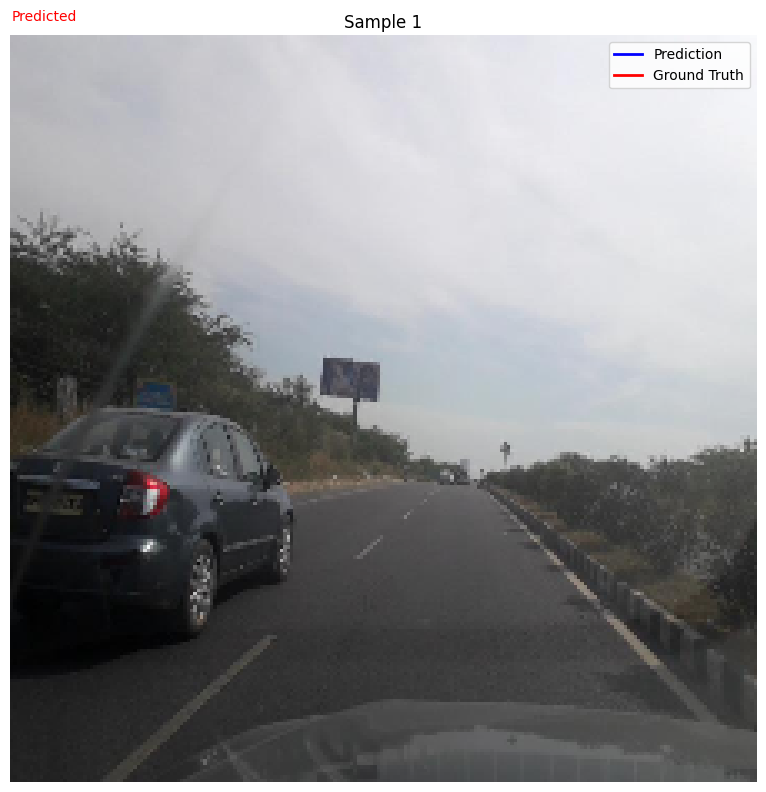

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
import matplotlib.pyplot as plt  # Importing the matplotlib.pyplot module

# Visualize predictions
visualize_predictions(X_val, predictions, y_val, num_samples=5)

# Calculate and print average IoU
avg_iou = evaluate_predictions(X_val[:100], predictions[:100], y_val[:100])
print(f"Average IoU: {avg_iou:.4f}")


In [ ]:
def visualize_predictions(images, predictions, annotations, num_samples=3):
    for idx in range(num_samples):
        image = images[idx]
        pred = predictions[idx]
        ann = annotations[idx]

        # Create figure and axes
        plt.figure(figsize=(12, 8))
        ax = plt.gca()

        # Convert BGR to RGB for display (if your images are in BGR format)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image_rgb)

        # Plot ground truth bounding boxes
        for bbox in ann:
            x_center, y_center, width, height = bbox
            x_min = (x_center - width / 2) * image.shape[1]
            y_min = (y_center - height / 2) * image.shape[0]
            x_max = (x_center + width / 2) * image.shape[1]
            y_max = (y_center + height / 2) * image.shape[0]
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

        # Plot predicted bounding boxes
        for bbox in pred:
            x_center, y_center, width, height = bbox
            x_min = (x_center - width / 2) * image.shape[1]
            y_min = (y_center - height / 2) * image.shape[0]
            x_max = (x_center + width / 2) * image.shape[1]
            y_max = (y_center + height / 2) * image.shape[0]
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        # Show the plot
        plt.show()


In [ ]:
def calculate_iou(pred_bbox, true_bbox):
    # Unnormalize boxes to image size (assuming image size is (height, width))
    pred_x_min = (pred_bbox[0] - pred_bbox[2] / 2)
    pred_y_min = (pred_bbox[1] - pred_bbox[3] / 2)
    pred_x_max = (pred_bbox[0] + pred_bbox[2] / 2)
    pred_y_max = (pred_bbox[1] + pred_bbox[3] / 2)

    true_x_min = (true_bbox[0] - true_bbox[2] / 2)
    true_y_min = (true_bbox[1] - true_bbox[3] / 2)
    true_x_max = (true_bbox[0] + true_bbox[2] / 2)
    true_y_max = (true_bbox[1] + true_bbox[3] / 2)

    # Compute intersection
    inter_x_min = max(pred_x_min, true_x_min)
    inter_y_min = max(pred_y_min, true_y_min)
    inter_x_max = min(pred_x_max, true_x_max)
    inter_y_max = min(pred_y_max, true_y_max)

    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    intersection_area = inter_width * inter_height

    # Compute union
    pred_area = (pred_x_max - pred_x_min) * (pred_y_max - pred_y_min)
    true_area = (true_x_max - true_x_min) * (true_y_max - true_y_min)

    union_area = pred_area + true_area - intersection_area

    # Compute IoU
    iou = intersection_area / union_area if union_area != 0 else 0
    return iou


In [ ]:
def visualize_predictions(images, predictions, annotations, num_samples=3):
    for idx in range(num_samples):
        image = images[idx]
        pred = predictions[idx]
        ann = annotations[idx]

        # Create figure and axes
        plt.figure(figsize=(12, 8))
        ax = plt.gca()

        # Convert BGR to RGB for display
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Display the image
        ax.imshow(image)

        # Plot ground truth bounding boxes (annotations)
        for ann_bbox in ann:
            x, y, w, h = ann_bbox
            rect = patches.Rectangle((x - w / 2, y - h / 2), w, h, linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)

        # Plot predicted bounding boxes
        for pred_bbox in pred:
            x, y, w, h = pred_bbox
            rect = patches.Rectangle((x - w / 2, y - h / 2), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

        # Add titles and labels
        ax.set_title(f"Sample {idx + 1}")
        ax.set_xlabel('Width')
        ax.set_ylabel('Height')

        # Show the plot
        plt.show()

TypeError: cannot unpack non-iterable numpy.float32 object

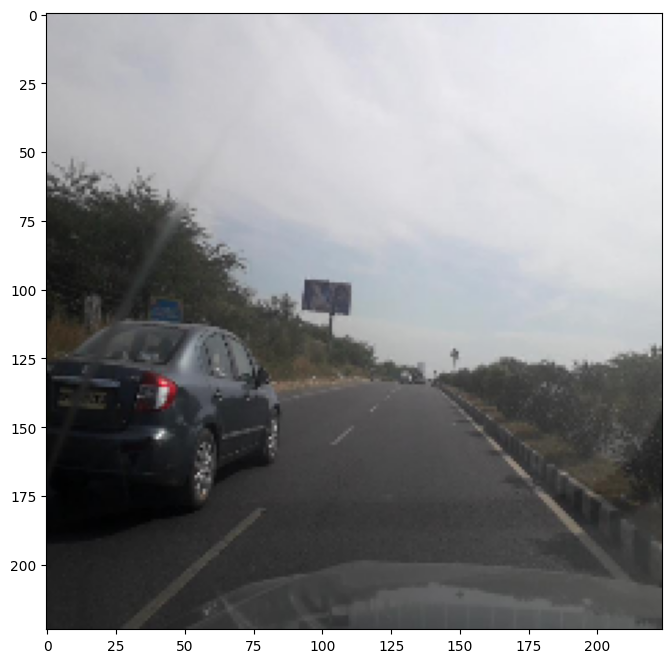

In [ ]:
# Visualize predictions
visualize_predictions(X_val, predictions, y_val, num_samples=10)

# Calculate and print average IoU
avg_iou = evaluate_predictions(X_val[:100], predictions[:100], y_val[:100])
print(f"Average IoU: {avg_iou:.4f}")

In [ ]:
def calculate_iou(pred_bbox, gt_bbox):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    
    Args:
    - pred_bbox: (center_x, center_y, width, height) for the predicted bounding box
    - gt_bbox: (center_x, center_y, width, height) for the ground truth bounding box

    Returns:
    - iou: Intersection over Union (IoU) score between the two bounding boxes
    """
    # Convert to corner coordinates (x1, y1, x2, y2) format (top-left, bottom-right)
    pred_x1 = pred_bbox[0] - pred_bbox[2] / 2
    pred_y1 = pred_bbox[1] - pred_bbox[3] / 2
    pred_x2 = pred_bbox[0] + pred_bbox[2] / 2
    pred_y2 = pred_bbox[1] + pred_bbox[3] / 2

    gt_x1 = gt_bbox[0] - gt_bbox[2] / 2
    gt_y1 = gt_bbox[1] - gt_bbox[3] / 2
    gt_x2 = gt_bbox[0] + gt_bbox[2] / 2
    gt_y2 = gt_bbox[1] + gt_bbox[3] / 2

    # Calculate the (x, y) coordinates of the intersection rectangle
    inter_x1 = max(pred_x1, gt_x1)
    inter_y1 = max(pred_y1, gt_y1)
    inter_x2 = min(pred_x2, gt_x2)
    inter_y2 = min(pred_y2, gt_y2)

    # Check if there is an intersection
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    # Calculate the areas of the prediction and ground truth boxes
    pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
    gt_area = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)

    # Calculate the union area
    union_area = pred_area + gt_area - inter_area

    # Calculate IoU
    iou = inter_area / union_area if union_area != 0 else 0

    return iou

# Example usage:
pred_bbox = (0.5, 0.5, 0.4, 0.4)  # (center_x, center_y, width, height)
gt_bbox = (0.6, 0.6, 0.5, 0.5)    # (center_x, center_y, width, height)

iou_score = calculate_iou(pred_bbox, gt_bbox)
print(f"IoU score: {iou_score:.4f}")


IoU score: 0.4261


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Load the trained model (replace with your actual model path)
model = tf.keras.models.load_model('rcnn_model.h5')  # or 'rcnn_model' for TensorFlow SavedModel

# Initialize webcam capture (0 is the default camera)
cap = cv2.VideoCapture(0)

# Ensure the webcam is opened correctly
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

# Define the input shape for the model (e.g., 224x224)
input_shape = (224, 224)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture frame.")
        break

    # Resize the frame to match model's input shape
    resized_frame = cv2.resize(frame, input_shape)
    
    # Preprocess the image (you can add any other preprocessing steps if needed)
    img_array = image.img_to_array(resized_frame)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalization (if required by your model)

    # Make predictions
    predictions = model.predict(img_array)

    # Assuming the model predicts bounding boxes (x, y, width, height) and confidence score
    for pred in predictions:
        # Decode bounding boxes (assuming prediction format is [x, y, w, h])
        x, y, w, h = pred
        # Draw a bounding box on the frame (assuming the model gives normalized coordinates)
        x1 = int(x * frame.shape[1])  # Convert normalized x to pixel value
        y1 = int(y * frame.shape[0])  # Convert normalized y to pixel value
        x2 = int((x + w) * frame.shape[1])
        y2 = int((y + h) * frame.shape[0])

        # Draw the bounding box (green color with thickness 2)
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Real-Time Object Detection', frame)

    # Exit the loop when the user presses 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the OpenCV window
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 